In [1]:
import os
import sys
import time
os.environ['TF_ENABLE_ONEDNN_OPTS'] = str(0)

import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras  # tf.keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipyparams
import json

print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

2023-06-20 03:21:00.602579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 03:21:00.797473: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-20 03:21:01.638911: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-06-20 03:21:01.639015: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic

<IPython.core.display.Javascript object>

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
matplotlib 3.5.3
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.10.1
keras.api._v2.keras 2.10.0


In [2]:
from test_utility import *

In [3]:
notebookName = os.path.basename(globals()['__vsc_ipynb_file__'])
if type(notebookName) == str and len(notebookName.split('.')) > 1:  # looks like running on VSCode
    pass
else:  # looks like running on a browser
    notebookName = ipyparams.notebook_name
assert type(notebookName) == str and len(notebookName.split('.')) > 2
notebookName = ".".join(notebookName.split('.')[:-2])   # -2: gets rid of train version and file extention.
print(notebookName)

data_model = notebookName  #"vm03.05.250.11.80.100.16.14.1"
assert len(notebookName.split('.')) >= 8

v2.05.300.11.80.eth,bnb.16.12


In [4]:
dir_data = "/mnt/data/Trading/"

#===================================================================== Dataset

Nx = 300 # ------------- test
Ny = 11
Ns = 5 #--------------------- test
BatchSize = 1024

Shift = 0 # past: 4

CandleFile = "18-01-01-00-00-23-05-20-20-23-5m"
SmallSigma = 1
LargeSigma = 30
eFreeNoLog = True

shuffle_batch = 30  # Keep it small to speed up model loading.

dir_candles = os.path.join(dir_data, "Candles")

min_true_candle_percent_x = 80
chosen_markets_x = []
chosen_fields_names_x = ['ClosePrice'] #, 'BaseVolume']
min_true_candle_percent_y = 80
assert min_true_candle_percent_x == min_true_candle_percent_y
chosen_markets_y = []
chosen_fields_names_y = ['ClosePrice']

target_market_names = None
# target_market_names = ['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT']
target_market_names = ['ETHUSDT', 'BNBUSDT']
tarket_market_top_percent = 15

Standardization = True
Kill_Irregulars = True  # ----------------- pls implement it
Time_into_X = True
Time_into_Y = False #
eFreeNoPlot = True

#======================================================================== Model

Num_Layers = 16 # Wow
Num_Heads = 1   # As we have a single GPU, and we want to a exhaustic attention.
Factor_FF = 4
repComplexity = 12  # Wower
Dropout_Rate = 0.  # train

dir_Checkpoint = os.path.join(dir_data, "Checkpoints")
checkpoint_filepath = os.path.join(dir_Checkpoint, data_model)
dir_CSVLogs = os.path.join(dir_data, "CSVLogs")
csvLogger_filepath = os.path.join(dir_CSVLogs, data_model)

#======================================================================== Train

Epochs_Initial = 5000
HuberThreshold = 4.0
Checkpoint_Monitor = "val_loss"
EarlyStopping_Min_Monitor = "val_loss"
EarlyStopping_Patience = 30

Optimizer = "adam"
Learning_Rate = 10e-9 # default: 0.001  # train

#=============================================================== Checksum

params = data_model.split('.')
assert int(params[1]) == int(CandleFile.split('-')[-1][:-1])
assert int(params[2]) == Nx
assert int(params[3]) == Ny
assert int(params[4]) == min_true_candle_percent_x
assert int(params[6]) == Num_Layers
assert int(params[7]) == repComplexity
targets = params[5]
if targets.isnumeric():
    assert target_market_names is None
    assert int(targets) == tarket_market_top_percent
else:
    for target in targets.split(','):
        assert (target+'usdt').upper() in target_market_names

#============================================================== Consistency
folders = [dir_data, dir_candles, dir_Checkpoint, dir_CSVLogs]
for folder in folders:
    if not os.path.isdir(folder):
        os.mkdir(folder)

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(gpus)
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # tf.config.experimental.set_virtual_device_configuration(
            #     gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)]) # why 5120?
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

mirrored_strategy = None
if len(gpus) > 1: 
    mirrored_strategy = tf.distribute.MirroredStrategy()
    Learning_Rate = Learning_Rate * len(gpus) * 3 / 4

# tf.config.experimental.set_virtual_device_configuration(
#     gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
#==================== Load candle data into 'table' with shape of (time, markets, 10 fields) ====================
Candles = np.load( os.path.join( dir_candles, "table-" + CandleFile + ".npy") )

with open( os.path.join( dir_candles, "reports-" + CandleFile + ".json"), "r") as f:
    reports = json.loads(f.read())

all_market_names = [ s[0: s.find(':')] for s in reports if 'Success' in s ]
assert Candles.shape[0] == len(all_market_names)
print(Candles.shape, len(all_market_names), all_market_names[:2])

all_field_names = ['ClosePrice', 'BaseVolume', 'BuyerBaseVolume']

(336, 565633, 10) 336 ['ALICEUSDT', 'DOTUSDT']


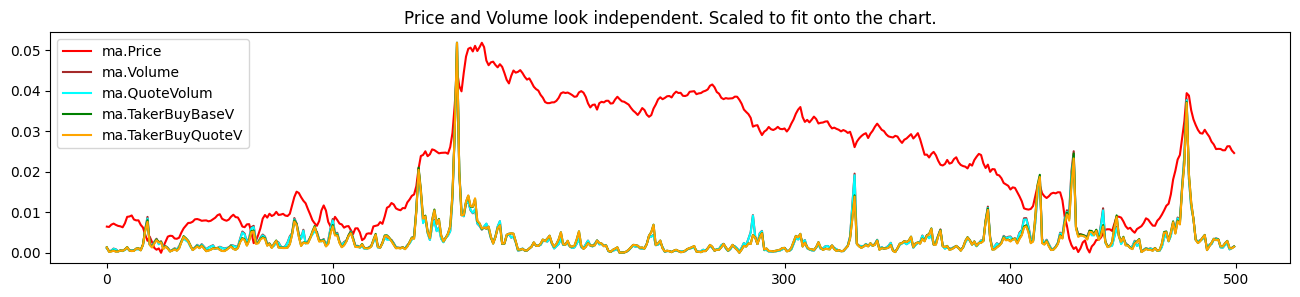

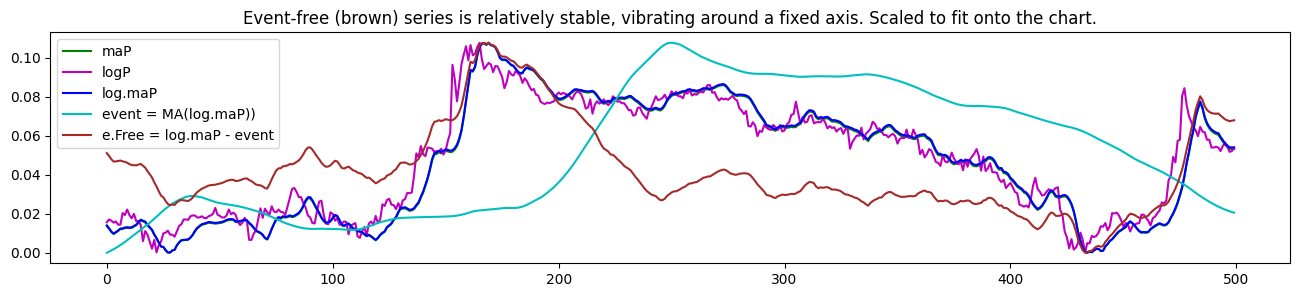

In [7]:
market = 5
Show_Price_Volume_10(Candles[market, :, :], 1, 1, 500)
Event_Free_Learning_Scheme_10(Candles[market, :, :], 3, 30, 500)

In [8]:
Candles, CandleMarks, all_market_names, x_indices, y_indices, \
chosen_market_names_x, chosen_field_names_x, chosen_market_names_y, chosen_field_names_y, \
chosen_market_names, chosen_field_names, \
target_markets_names, target_markets = \
get_formed_data_2(
        Candles, all_market_names, all_field_names, 
        min_true_candle_percent_x, chosen_fields_names_x, min_true_candle_percent_y, chosen_fields_names_y,
        target_market_names, tarket_market_top_percent
)

print(Candles.shape)
print(CandleMarks.shape)
print(len(all_market_names))
print(x_indices)
print(y_indices)
print(chosen_market_names_x)
print(chosen_field_names_x)
print(chosen_market_names_y)
print(chosen_field_names_y)
print(chosen_market_names)
print(chosen_field_names)
print(target_markets_names)
print(target_markets)
print(len(chosen_market_names_x), len(chosen_market_names_y), len(target_markets_names))

(565633, 19, 1)
(565633, 19)
336
((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18), (0,))
((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18), (0,))
['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT', 'EOSUSDT', 'XLMUSDT', 'IOTAUSDT', 'ONTUSDT', 'TRXUSDT', 'ETCUSDT', 'ICXUSDT', 'NULSUSDT', 'VETUSDT', 'LINKUSDT', 'WAVESUSDT']
['ClosePrice']
['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT', 'EOSUSDT', 'XLMUSDT', 'IOTAUSDT', 'ONTUSDT', 'TRXUSDT', 'ETCUSDT', 'ICXUSDT', 'NULSUSDT', 'VETUSDT', 'LINKUSDT', 'WAVESUSDT']
['ClosePrice']
['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT', 'EOSUSDT', 'XLMUSDT', 'IOTAUSDT', 'ONTUSDT', 'TRXUSDT', 'ETCUSDT', 'ICXUSDT', 'NULSUSDT', 'VETUSDT', 'LINKUSDT', 'WAVESUSDT']
['ClosePrice']
['ETHUSDT', 'BNBUSDT']
(3, 4)
19 19 2


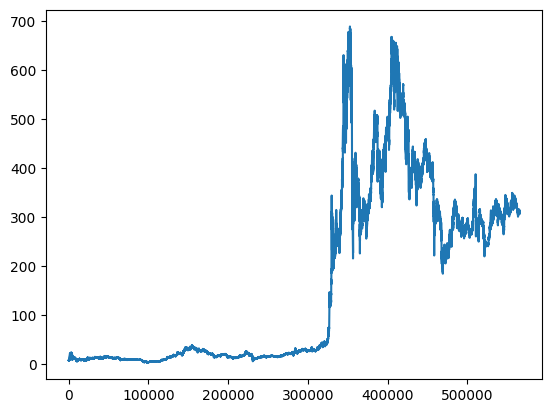

In [9]:
market = all_market_names.index("BNBUSDT")
plt.plot(Candles[:, market, 0])
plt.show()

In [10]:
start_ts, interval_s, timestamps_abs = get_timestamps_2(CandleFile, Candles.shape[0])
print(start_ts, interval_s, timestamps_abs.shape, timestamps_abs[:3])

Times = get_time_features(timestamps_abs)
Times = Times.astype(Candles.dtype)
size_time = Times.shape[1]

assert Candles.shape[0] == Times.shape[0]
print(Candles.shape, Times.shape)
print(timestamps_abs[:5])
# print(Times[:5])    # Agnostic of restart of this training notebook.

1514764800 300 (565633,) [1514764800 1514765100 1514765400]
(565633, 19, 1) (565633, 4)
[1514764800 1514765100 1514765400 1514765700 1514766000]


In [11]:
#==================== Generate event-free data into Data ====================
# Data loses heading items.
# Do it before: Permute Data in time

alpha = 3; beta = 3 # beta is used in 'get_eFree_with_plot'. Ugly coupling.
event_free_data_loss = 3 * ( alpha * SmallSigma + LargeSigma)
eFree = np.zeros( (Candles.shape[0] - event_free_data_loss, len(chosen_market_names), len(chosen_field_names)), dtype = Candles.dtype )

for market in range(Candles.shape[1]):
    for field in range(Candles.shape[2]):
        sSigma = SmallSigma
        if all_field_names[field] == 'BaseVolume': sSigma = SmallSigma * alpha
        P, maP, logP, log_maP, event, eventFree = \
        get_eFree_with_plot(all_market_names[market], all_field_names[field], Candles[:, market, field], sSigma,
                            LargeSigma, Candles.shape[0] - event_free_data_loss, noPlot=eFreeNoPlot, noLog=eFreeNoLog)
        assert Candles.shape[0] - event_free_data_loss == eventFree.shape[0]
        eventFree = eventFree.astype(Candles.dtype)
        Candles[event_free_data_loss:, market, field] = eventFree

Candles = Candles[event_free_data_loss + Shift:]
Times = Times[event_free_data_loss + Shift:]
assert Candles.shape[0] == Times.shape[0]

print(Candles.shape, Times.shape)
# print(Candles[-3:]) # Agnostic of restart of this training notebook.

(565534, 19, 1) (565534, 4)


In [12]:
Standard = None

if Standardization:
    Candles, Standard = standardize_2(Candles)
# print(Candles[-3:]) # Agnostic of restart of this training notebook.

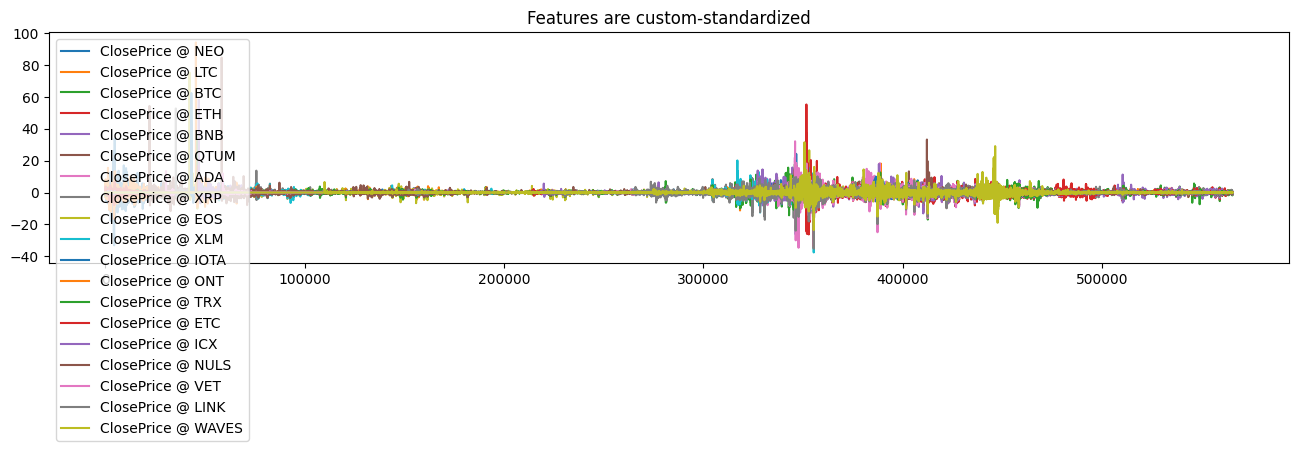

In [13]:
fig = plt.figure(figsize=(16,3))
ax = fig.add_subplot(111)
ax.set_title("Features are custom-standardized" if Standardization else "Features are not standardized")
for market in range(Candles.shape[1]):
    for field in range(Candles.shape[2]):
        ax.plot(Candles[:, market, field], label = "{} @ {}".format(all_field_names[field], all_market_names[market][:-len('USDT')]))
ax.legend(loc = 'upper left')
plt.show()

In [14]:
sample_anchores_t, sample_anchores_v = get_sample_anchors_2(Candles, Nx, Ny, Ns, seed=523)
print(sample_anchores_t.shape, sample_anchores_v.shape)
# print(sample_anchores_t) # Agnostic of restart of this training notebook.
print(sample_anchores_t[:5])
assert sample_anchores_t[0] == 104325
assert sample_anchores_t[1] == 279190

(79131,) (33914,)
[104325 279190 380975 ... 484255 337305 472300]


In [15]:
ds_train, ds_valid, dx, dy = \
get_datasets_2(
    Candles, Time_into_X, Time_into_Y, Times, 
    sample_anchores_t, sample_anchores_v,
    Nx, x_indices, Ny, y_indices, size_time, target_markets,
    BatchSize, shuffle_batch, shuffle=(len(gpus)<=1)
)

2023-06-20 03:21:21.164674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 03:21:21.854350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38239 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [16]:
model = None

if mirrored_strategy is None:
    model = build_model_2(
        dx, dy, Num_Layers, Num_Heads, Factor_FF, repComplexity, Dropout_Rate,
        HuberThreshold, Optimizer, Learning_Rate
    )
else:
    with mirrored_strategy.scope():
        model = build_model_2(
            dx, dy, Num_Layers, Num_Heads, Factor_FF, repComplexity, Dropout_Rate,
            HuberThreshold, Optimizer, Learning_Rate
        )

In [17]:
model_loaded = False

callbacks = get_callbacks(
    checkpoint_filepath, Checkpoint_Monitor, 
    csvLogger_filepath, 
    EarlyStopping_Min_Monitor, EarlyStopping_Patience
)

try:
    model.load_weights(checkpoint_filepath)
    print("Loading a checkpoint...")
    model_loaded = True
except:
    print("No chekkpoint to load.")
    pass

Loading a checkpoint...


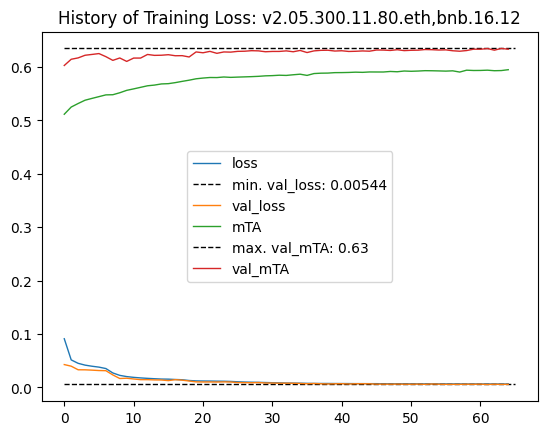

In [18]:
if model_loaded:
    try:
        columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
        plot_csv_train_history(csvLogger_filepath, columns, title=data_model)
    except:
        pass
else:
    model.fit(
        ds_train, # x and y_true
        validation_data=ds_valid,
        epochs=1, #Epochs_Initial,
        callbacks=callbacks
    )

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 candle_input_x (InputLayer)    [(None, None, 24)]   0           []                               
                                                                                                  
 candle_input_y (InputLayer)    [(None, None, 24)]   0           []                               
                                                                                                  
 trans (ConTransformer)         (None, None, 24)     385560      ['candle_input_x[0][0]',         
                                                                  'candle_input_y[0][0]']         
                                                                                                  
Total params: 385,560
Trainable params: 385,560
Non-trainable params: 0
______________________

In [20]:
model.fit(
    ds_train, # x and y_true
    validation_data=ds_valid,
    epochs=20, #Epochs_Initial,
    callbacks=callbacks
)

Epoch 1/20


2023-06-20 03:22:30.708380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 15517 of 30720
2023-06-20 03:22:40.454419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-06-20 03:22:42.038035: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-20 03:22:42.758431: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


78/78 [==============================] - ETA: 0s - loss: 0.0065 - mTA: 0.5944

2023-06-20 03:23:55.837876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 15383 of 30720
2023-06-20 03:24:05.840769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 30578 of 30720
2023-06-20 03:24:05.935217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


78/78 [==============================] - 164s 1s/step - loss: 0.0065 - mTA: 0.5944 - val_loss: 0.0059 - val_mTA: 0.6316
Epoch 2/20
78/78 [==============================] - 62s 793ms/step - loss: 0.0065 - mTA: 0.5941 - val_loss: 0.0057 - val_mTA: 0.6316
Epoch 3/20
78/78 [==============================] - 59s 762ms/step - loss: 0.0064 - mTA: 0.5950 - val_loss: 0.0059 - val_mTA: 0.6339
Epoch 4/20
78/78 [==============================] - 62s 793ms/step - loss: 0.0064 - mTA: 0.5946 - val_loss: 0.0055 - val_mTA: 0.6341
Epoch 5/20
78/78 [==============================] - 59s 761ms/step - loss: 0.0064 - mTA: 0.5941 - val_loss: 0.0060 - val_mTA: 0.6332
Epoch 6/20
78/78 [==============================] - 59s 761ms/step - loss: 0.0064 - mTA: 0.5925 - val_loss: 0.0055 - val_mTA: 0.6335
Epoch 7/20
78/78 [==============================] - 59s 762ms/step - loss: 0.0063 - mTA: 0.5948 - val_loss: 0.0055 - val_mTA: 0.6337
Epoch 8/20
78/78 [==============================] - 59s 762ms/step - loss: 0.0063 

43/78 [===============>..............] - ETA: 22s - loss: 0.0063 - mTA: 0.5962

In [ ]:
columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
plot_csv_train_history(csvLogger_filepath, columns, title=data_model)

In [ ]:
model.fit(
    ds_train, # x and y_true
    validation_data=ds_valid,
    epochs=50, #Epochs_Initial,
    callbacks=callbacks
)

In [ ]:
columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
plot_csv_train_history(csvLogger_filepath, columns, title=data_model)

In [ ]:
model.fit(
    ds_train, # x and y_true
    validation_data=ds_valid,
    epochs=500, #Epochs_Initial,
    callbacks=callbacks
)

In [ ]:
columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
plot_csv_train_history(csvLogger_filepath, columns, title=data_model)

In [ ]:
model.fit(
    ds_train, # x and y_true
    validation_data=ds_valid,
    epochs=500, #Epochs_Initial,
    callbacks=callbacks
)

In [ ]:
columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
plot_csv_train_history(csvLogger_filepath, columns, title=data_model)

In [ ]:
model.fit(
    ds_train, # x and y_true
    validation_data=ds_valid,
    epochs=500, #Epochs_Initial,
    callbacks=callbacks
)

In [ ]:
columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
plot_csv_train_history(csvLogger_filepath, columns, title=data_model)